# Bokeh Exercise: Making a Dashboard

In this exercise we will make a simple interactive dashboard for data analysis to illustrate the power of Bokeh.

# Introduction: Loading the dataset

In [51]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve,classification_report,precision_recall_curve,average_precision_score,auc
from bokeh.plotting import figure, output_file, show, reset_output
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import Legend
from ipywidgets import interact
reset_output()
output_notebook()
import warnings
warnings.simplefilter(action='ignore')

Loading BokehJS ...

We will be using the accompanying dataset `bokeh_data.csv.gz` with input features `A-D` and target variable `label`:

In [2]:
df = pd.read_csv('bokeh_data.csv.gz', compression='gzip')

The data also are ordered in time. For convenience, we convert the `date` column to the Pandas datetime data type:

In [3]:
df.date = pd.to_datetime(df.date)

In [4]:
df.shape

(39240, 7)

In [5]:
df.tail()

,Unnamed: 0,A,B,C,D,label,date
39235,39235,0.000550,0.0,0.00121,0.100000,0,2018-12-13
39236,39236,0.000000,0.0,0.00000,0.571429,1,2018-12-13
39237,39237,0.000000,0.0,0.00000,0.071429,1,2018-12-13
39238,39238,0.000766,0.0,0.00000,0.500000,1,2018-12-13
39239,39239,0.000000,0.0,0.00000,0.176471,0,2018-12-13


In [6]:
df.label.value_counts()

0    19967
1    19273
Name: label, dtype: int64

For reference, date properties like year, month, day can be accessed using `Series.dt`, for example:

# Part 1: Training a classifier 

We now want to build a model that predicts the target `label` from features `A-D` and compare its performance across time.

**Questions:**
### 1. Split the data into train and test sets, using the first three months of data as the training set (`X_train` and `y_train`), and the last month of data as the test set (`X_test` and `y_test`). Note: `date` will not be used as an input feature, so do not include its value in `X_train` or `X_test`.


In [7]:
split_date = 11

X_train = X_train = df[df.date.dt.month <= split_date].drop(['Unnamed: 0','date','label'], axis=1).copy()

y_train =df.label[df.date.dt.month <= split_date]

X_test = df[df.date.dt.month > split_date].drop(['Unnamed: 0','date','label'], axis=1).copy()

y_test = df.label[df.date.dt.month > split_date]

In [8]:
X_train

,A,B,C,D
0,0.000000,0.0,0.000019,0.500000
1,0.000000,0.0,0.000019,0.500000
2,0.000948,0.0,0.000000,0.541667
3,0.000000,0.0,0.000000,0.266667
4,0.000000,0.0,0.000000,0.375000
...,...,...,...,...
34446,0.000000,0.0,0.000000,0.000000
34447,0.000000,0.0,0.000000,0.000000
34448,0.000000,0.0,0.000053,0.428571
34449,0.000326,0.0,0.001631,0.117647


In [9]:
y_train

0        1
1        1
2        1
3        0
4        0
        ..
34446    0
34447    0
34448    1
34449    0
34450    1
Name: label, Length: 34451, dtype: int64

In [10]:
X_test

,A,B,C,D
34451,0.000000,0.0,0.00267,0.307692
34452,0.000000,0.0,0.00000,0.920000
34453,0.000000,0.0,0.00000,0.444444
34454,0.000000,0.0,0.00000,0.200000
34455,0.000000,0.0,0.00000,0.126667
...,...,...,...,...
39235,0.000550,0.0,0.00121,0.100000
39236,0.000000,0.0,0.00000,0.571429
39237,0.000000,0.0,0.00000,0.071429
39238,0.000766,0.0,0.00000,0.500000


In [11]:
y_test

34451    0
34452    1
34453    0
34454    1
34455    0
        ..
39235    0
39236    1
39237    1
39238    1
39239    0
Name: label, Length: 4789, dtype: int64

### 2. Train a random forest classifier (`sklearn.ensemble.RandomForestClassifier`) to predict `label` from `A-D`, using the first three months of data as the training set. Use `sklearn.metrics.classification_report` to find the precision and recall of this classifier on the test set (for `label`=1).


Use GridSearchCV to find the best parametrs for our model

In [12]:
model = RandomForestClassifier()

params_clf = dict(n_estimators = np.arange(50,300,50),
                  max_depth = np.arange(1,16,2),
                  max_leaf_nodes = np.arange(1,10))
grid_search_clf = GridSearchCV(model, param_grid = params_clf, cv =3, scoring='recall')
grid_search_clf.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15]),
                         'max_leaf_nodes': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 50, 100, 150, 200, 250])},
             scoring='recall')

Best params for our model are:

In [13]:
grid_search_clf.best_params_

{'max_depth': 11, 'max_leaf_nodes': 9, 'n_estimators': 50}

Now we will train our model with best params

In [20]:
clf_forest = RandomForestClassifier(n_estimators=50,max_depth=11, max_leaf_nodes=9,random_state=2)
clf_forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=11, max_leaf_nodes=9, n_estimators=50,
                       random_state=2)

In [36]:
y_pred_forest = clf_forest.predict(X_test)

Let's see classification_report on our model(for label=1)

In [37]:
def get_stats(model, x_test_input=X_test, y_test_input=y_test,
             x_train_inp=X_train, y_train_inp=y_train):
    y_pred = np.round(model.predict(x_test_input))
    y_pred_train = np.round(model.predict(x_train_inp))
    accuracy_test = metrics.accuracy_score(y_test_input, y_pred)
    accuracy_train = metrics.accuracy_score(y_train_inp, y_pred_train)
    print("Accuracy Test: {0}".format(round(accuracy_test, 3)))
    print("Accuracy Train: {0}".format(round(accuracy_train, 3)))
    print(classification_report(y_test_input, y_pred))

In [38]:
get_stats(clf_forest, x_test_input=X_test, y_test_input=y_test,
             x_train_inp=X_train, y_train_inp=y_train)

Accuracy Test: 0.806
Accuracy Train: 0.798
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      2472
           1       0.89      0.69      0.77      2317

    accuracy                           0.81      4789
   macro avg       0.82      0.80      0.80      4789
weighted avg       0.82      0.81      0.80      4789



Here we see, that for this classifier on the test set (for label=1) the precision = 0.89 and recall = 0.69 

### 3. Instead of using the default threshold for classification, we can use different thresholds on scores to adjust precision and recall. Using `predict_proba(...)` and `sklearn.metrics.precision_recall_curve`, plot a precision-recall curve for the classifier. (You may use matplotlib for the plot.)

In [39]:
y_scores = clf_forest.predict_proba(X_test)[:, 1]

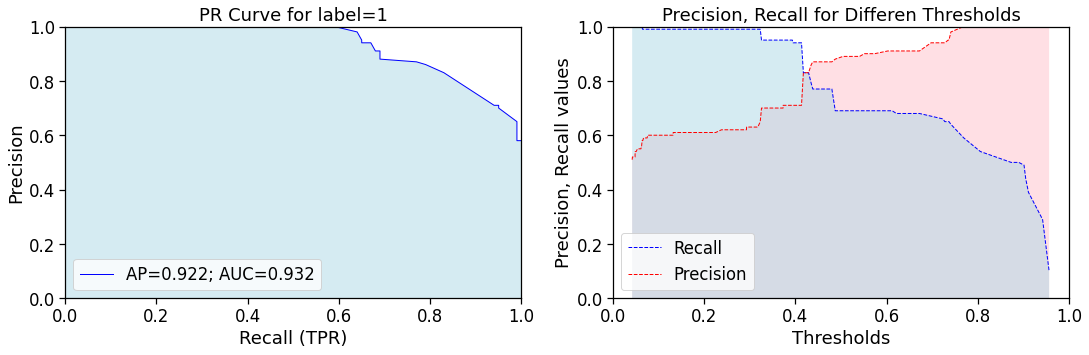

In [40]:

fig = plt.figure(figsize = (18,5))

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores , pos_label=1)
precision, recall = np.round(precision, 2), np.round(recall, 2)

# average precision score
avg_precision = average_precision_score(y_test, y_scores,pos_label=1)

# precision auc
pr_auc = auc(recall, precision)

ax1 = plt.subplot(121)
ax1.plot(recall, precision, lw=1, color='blue', label=f'AP={round(avg_precision,3)}; AUC={round(pr_auc,3)}') 
ax1.fill_between(recall, precision,-1, facecolor='lightblue', alpha=0.5)
plt.xlabel('Recall (TPR)')
plt.ylim(0,1)
plt.xlim(0,1)
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('PR Curve for label=1');


ax2 = plt.subplot(122)
ax2.plot(thresholds, recall[:-1],"b--", lw=1, color='blue', label='Recall') 
ax2.plot(thresholds, precision[:-1],"b--", lw=1, color='red', label='Precision') 
ax2.fill_between(thresholds, precision[:-1],-1, facecolor='pink', alpha=0.5)
ax2.fill_between(thresholds, recall[:-1],-1, facecolor='lightblue', alpha=0.5)
plt.xlabel('Thresholds')
plt.ylim(0,1)
plt.xlim(0,1)
plt.ylabel('Precision, Recall values')
plt.legend(loc="lower left")
plt.title('Precision, Recall for Differen Thresholds');

On the plot we see, that average precision score gives us a high result of accuracy

# Part 2: Building a dashboard

After training the model on the first three months, you want to visualize how the model performed on each day of the last month (December).

## Questions:

**4. Write a function `get_pr_for_day(day, threshold)` that given a day (integer 1-30) and score threshold value, returns the tuple (precision, recall) for the classifier on the test data from that given day.**


In [41]:

def get_pr_for_day(day, threshhold_new):
    
    X_test_day = df[(df.date.dt.month == 12) & (df.date.dt.day == day)]. \
    drop(['Unnamed: 0','date','label'], axis=1)

    y_test_day = df[(df.date.dt.month == 12) & 
                    (df.date.dt.day == day)]['label']
    
    y_pred_proba = clf_forest.predict_proba(X_test_day)[:,1]
    
    # calculate precision-recall 
    precision, recall, threshhold = precision_recall_curve(y_test_day,
                                                           y_pred_proba,
                                                           pos_label=1)
    
    indx = (np.abs(np.array(threshhold) - np.array(threshhold_new))).argmin()

    return (precision[indx],recall[indx])

In [42]:
get_pr_for_day(5, 0.3)

(0.6153846153846154, 0.9904761904761905)

**5. Create a Bokeh plot containing line plots of precision (in blue) and recall (in red), for threshold=0.5. The x axis should be the day in December, and the y axis should be the precision/recall rate. Use `output_nodebook()` so that it displays inline in your Jupyter notebook. Note: You can adjust the plot's width and height and the range of the y axis with `figure(..., plot_width=..., plot_height=..., y_range=...)`.**


Take unique days from last month

In [43]:

days = np.unique(df.date.dt.day[(df.date.dt.month == 12)]).tolist()
days

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Create list of precision and recall by days in December

Function to get Precision and Recall for December by Days and threshold

In [46]:
def get_list_prec_rec(days, threshold):
    precision_list = []
    recall_list = []
    for day in days:
        precision_list.append(get_pr_for_day(day, threshold)[0])
        recall_list.append(get_pr_for_day(day, threshold)[1])
    return np.array(precision_list), np.array(recall_list)

In [50]:

precision_list = get_list_prec_rec(days, 0.5)[0]
recall_list = get_list_prec_rec(days, 0.5)[1]
    
precision_list,recall_list

(array([0.87027027, 0.88      , 0.86934673, 0.86772487, 0.86702128,
        0.82291667, 0.93452381, 0.9039548 , 0.83505155, 0.8974359 ,
        0.87323944, 0.82608696, 0.75      ]),
 array([0.805     , 0.75862069, 0.79723502, 0.77725118, 0.77619048,
        0.79396985, 0.72685185, 0.76923077, 0.76056338, 0.66985646,
        0.74698795, 0.61290323, 0.6       ]))

Draw Bokeh plot of Precision and Recall for December by Days

In [49]:
p = figure(tools="pan,wheel_zoom,box_select,reset",
           title="Precision and Recall for December by Days",
           x_axis_label='12 days of December',
           y_axis_label='Precision/Recall Rate',
           plot_width=900, plot_height=300, y_range=[0, 1]
            )

# add a line renderer with legend and line thickness
p1 = p.line(days, precision_list,
        legend_label="Precision", 
        line_width=2,
        line_color="blue")
p2 = p.line(days, recall_list,
        legend_label="Recall", 
        line_width=2,
        line_color="red")

#show result
show(p, notebook_handle=True);

**6. Make the figure interactive by adding a slider bar with the classifier's threshold value. As you slide the bar between 0 and 1, the precision and recall line plots should change accordingly. Hints: Make sure to use `notebook_handle=True` in `show(...)`, define your update callback `update(threshold)`, and then use `ipywidgets.interact(update, threshold=(0, 1, 0.01))`.**


In [47]:
def update(threshold):
    
    precision_list,recall_list = get_list_prec_rec(days, threshold)
    p1.data_source.data['y'] = precision_list
    p2.data_source.data['y'] = recall_list
    push_notebook()


show(p, notebook_handle=True)
interact(update, threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…


## Bonus: 
<br>**Why did we use `threshold=(0, 1, 0.01)` above instead of `threshold=(0, 1)`?**

Because we have to sent also step for values